In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files



In [18]:


# Function to validate weights and impacts
def validate_inputs(weights, impacts, num_criteria):
    if len(weights) != num_criteria or len(impacts) != num_criteria:
        raise ValueError("Weights and impacts must match the number of criteria.")
    if not all(i in ['+', '-'] for i in impacts):
        raise ValueError("Impacts must be '+' or '-'.")
    return weights, impacts

# Function to perform TOPSIS calculation
def calculate_topsis(decision_matrix, weights, impacts):
    # Step 1: Normalize the decision matrix
    normalized_matrix = decision_matrix / np.sqrt((decision_matrix ** 2).sum(axis=0))


    # Step 2: Weighted normalized decision matrix
    weighted_matrix = normalized_matrix * weights

    # Step 3: Determine ideal best and worst
    ideal_best = np.where(np.array(impacts) == '+', weighted_matrix.max(axis=0), weighted_matrix.min(axis=0))
    ideal_worst = np.where(np.array(impacts) == '+', weighted_matrix.min(axis=0), weighted_matrix.max(axis=0))

    # Step 4: Calculate distances from ideal best and worst
    dist_best = np.sqrt(((weighted_matrix - ideal_best) ** 2).sum(axis=1))
    dist_worst = np.sqrt(((weighted_matrix - ideal_worst) ** 2).sum(axis=1))

    # Step 5: Calculate TOPSIS score
    topsis_score = dist_worst / (dist_best + dist_worst)
    return topsis_score



In [19]:
# Load the CSV file
file_path = "text_generation_models.csv"  # Path to the uploaded file
df = pd.read_csv(file_path)

# Display the decision matrix
print("Decision Matrix:")
display(df)

# Extract decision matrix (excluding model names)
decision_matrix = df.iloc[:, 1:].values  # Assuming first column is Model names
models = df.iloc[:, 0].tolist()          # Extract Model names


Decision Matrix:


,Model,Perplexity (PPL),BLEU Score,ROUGE Score,Diversity Metrics,Latency,Memory Usage
0,GPT-4,90,96,100,89,78,74
1,Gemini 1.5 Pro,86,97,94,100,74,74
2,Claude 2.1,64,88,100,76,76,59
3,LLaMA 2,68,93,89,82,88,53
4,MPT-30B,72,89,85,79,85,60


In [21]:

# Define weights and impacts
weights = [0.25, 0.20, 0.15,0.15, 0.10, 0.15]  # Modify as needed
impacts = ['-', '+', '+', '+', '-','-']        # Beneficial (+) and non-beneficial (-) criteria

# Validate inputs
weights, impacts = validate_inputs(weights, impacts, decision_matrix.shape[1])

# Apply TOPSIS
topsis_scores = calculate_topsis(decision_matrix, weights, impacts)

# Add TOPSIS scores and rankings to the DataFrame
df['Topsis Score'] = topsis_scores
df['Rank'] = df['Topsis Score'].rank(ascending=False).astype(int)

# Display final results
print("TOPSIS Results:")
display(df)

# Optional: Save the results to a CSV file
df.to_csv('Results.csv', index=False)
print("Results saved to 'topsis_results.csv'")


TOPSIS Results:


,Model,Perplexity (PPL),BLEU Score,ROUGE Score,Diversity Metrics,Latency,Memory Usage,Topsis Score,Rank
0,GPT-4,90,96,100,89,78,74,0.282628,5
1,Gemini 1.5 Pro,86,97,94,100,74,74,0.378511,4
2,Claude 2.1,64,88,100,76,76,59,0.664476,2
3,LLaMA 2,68,93,89,82,88,53,0.672289,1
4,MPT-30B,72,89,85,79,85,60,0.537813,3


Results saved to 'topsis_results.csv'


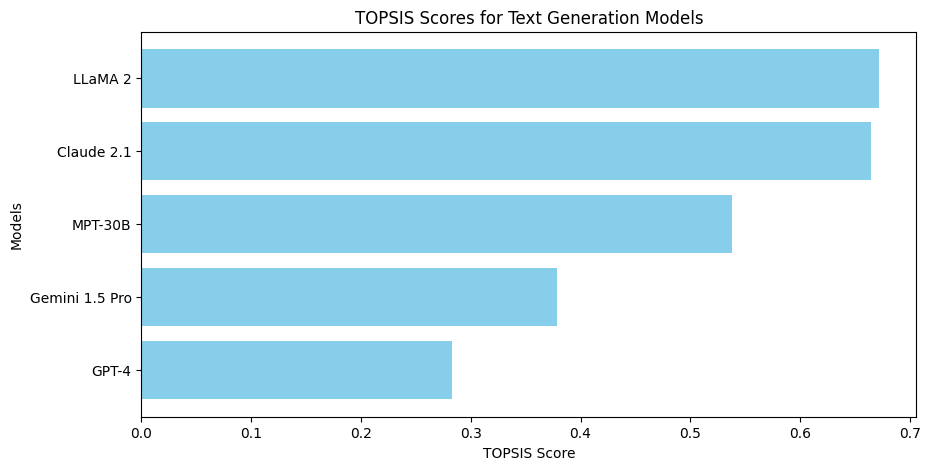

In [22]:

# Sort by TOPSIS Score for better visualization
df_sorted = df.sort_values(by="Topsis Score", ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(df_sorted["Model"], df_sorted["Topsis Score"], color="skyblue")
plt.xlabel("TOPSIS Score")
plt.ylabel("Models")
plt.title("TOPSIS Scores for Text Generation Models")
plt.show()


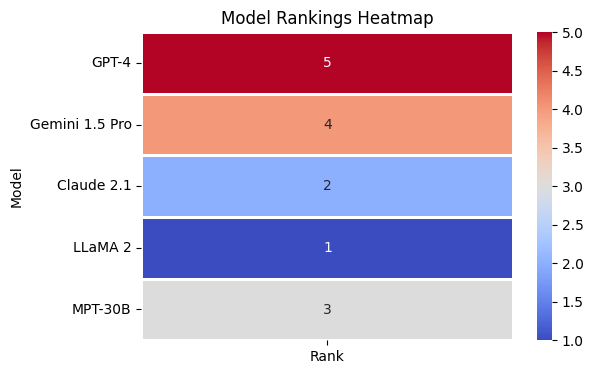

In [23]:

plt.figure(figsize=(6, 4))
sns.heatmap(df.set_index("Model")[["Rank"]], annot=True, cmap="coolwarm", fmt="d", linewidths=1)
plt.title("Model Rankings Heatmap")
plt.show()


In [24]:
import plotly.graph_objects as go

# Normalizing values for radar chart
df_radar = df.copy()
df_radar.iloc[:, 1:-2] = df_radar.iloc[:, 1:-2].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

fig = go.Figure()

for i in range(len(df_radar)):
    fig.add_trace(go.Scatterpolar(
        r=df_radar.iloc[i, 1:-2].values,
        theta=df_radar.columns[1:-2],
        fill='toself',
        name=df_radar.iloc[i, 0]
    ))

fig.update_layout(polar=dict(radialaxis=dict(visible=True)), title="Model Comparison Radar Chart")
fig.show()


<ipython-input-24-d3d32d9f7020>:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    1.000000
1    0.846154
2    0.000000
3    0.153846
4    0.307692
Name: Perplexity (PPL), dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-24-d3d32d9f7020>:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    0.888889
1    1.000000
2    0.000000
3    0.555556
4    0.111111
Name: BLEU Score, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-24-d3d32d9f7020>:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    1.000000
1    0.600000
2    1.000000
3    0.266667
4    0.000000
Name: ROUGE Score, dtype: float64' has dtype incompatible with int64, please e

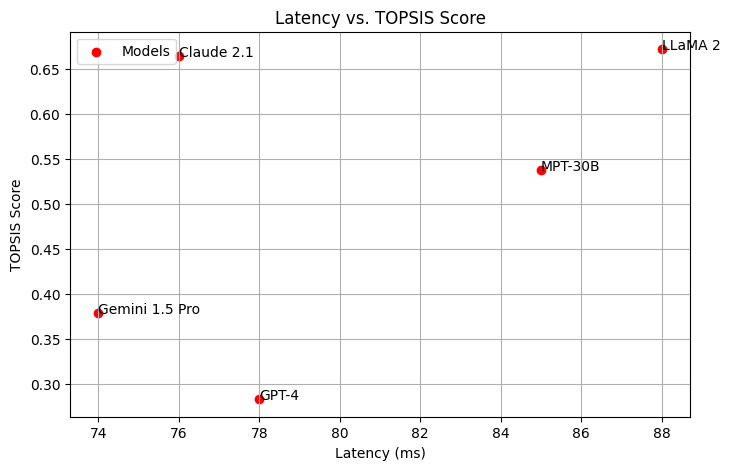

In [25]:
plt.figure(figsize=(8, 5))
plt.scatter(df["Latency"], df["Topsis Score"], color="red", label="Models")
plt.xlabel("Latency (ms)")
plt.ylabel("TOPSIS Score")
plt.title("Latency vs. TOPSIS Score")
plt.grid(True)

for i, txt in enumerate(df["Model"]):
    plt.annotate(txt, (df["Latency"][i], df["Topsis Score"][i]), fontsize=10)

plt.legend()
plt.show()
